In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import cv2 as cv
from torchvision import models, transforms

In [2]:
# load the model
model = models.resnet50(pretrained=True)
#print(model)
model_weights = [] # we will save the conv layer weights in this list
conv_layers = [] # we will save the 49 conv layers in this list
# get all the model children as list
model_children = list(model.children())

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [3]:
counter = 0 
# append all the conv layers and their respective weights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter += 1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    counter += 1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Total convolutional layers: {counter}")

Total convolutional layers: 49


In [4]:
for weight, conv in zip(model_weights, conv_layers):
    # print(f"WEIGHT: {weight} \nSHAPE: {weight.shape}")
    print(f"CONV: {conv} ====> SHAPE: {weight.shape}")

CONV: Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False) ====> SHAPE: torch.Size([64, 3, 7, 7])
CONV: Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False) ====> SHAPE: torch.Size([64, 64, 1, 1])
CONV: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) ====> SHAPE: torch.Size([64, 64, 3, 3])
CONV: Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False) ====> SHAPE: torch.Size([256, 64, 1, 1])
CONV: Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False) ====> SHAPE: torch.Size([64, 256, 1, 1])
CONV: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) ====> SHAPE: torch.Size([64, 64, 3, 3])
CONV: Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False) ====> SHAPE: torch.Size([256, 64, 1, 1])
CONV: Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False) ====> SHAPE: torch.Size([64, 256, 1, 1])
CONV: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False

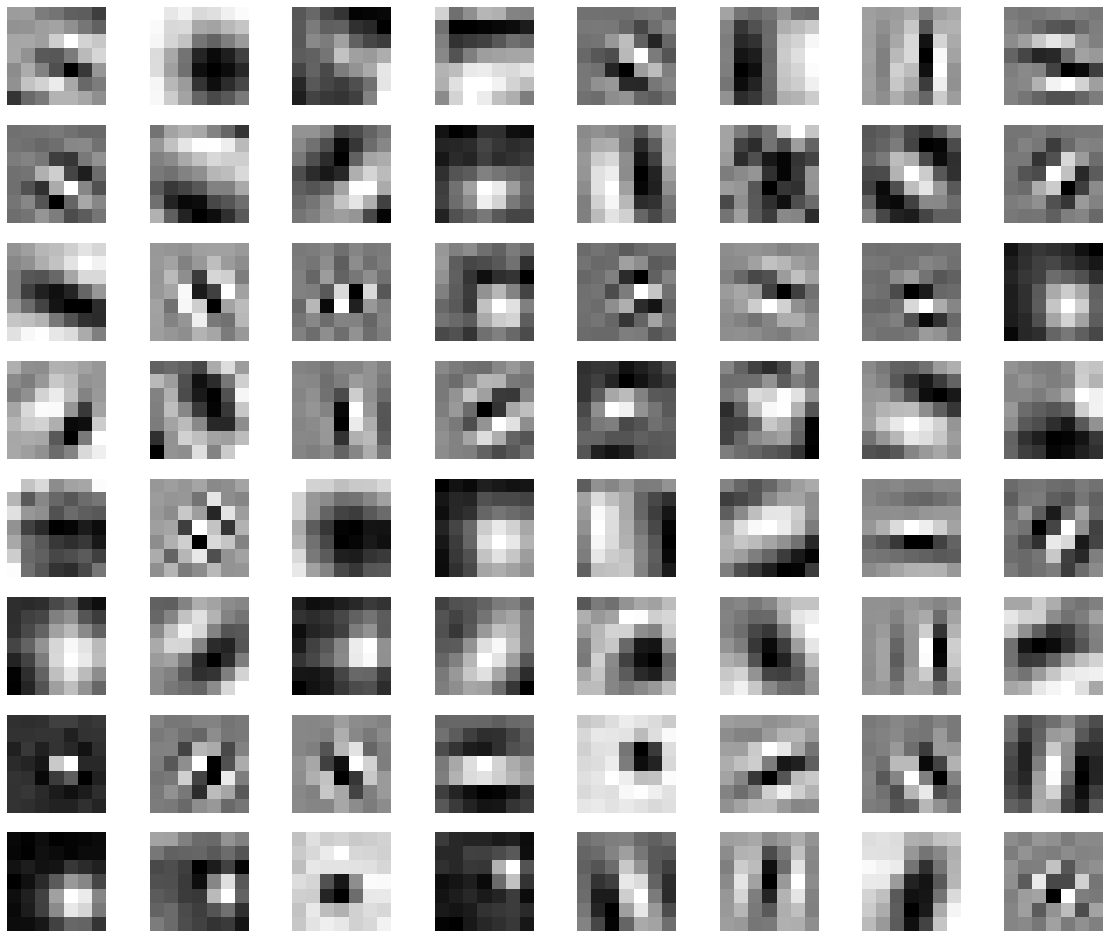

In [6]:
# visualize the first conv layer filters
plt.figure(figsize=(20, 17))
for i, filter in enumerate(model_weights[0]):
    plt.subplot(8, 8, i+1) # (8, 8) because in conv0 we have 7x7 filters and total of 64 (see printed shapes)
    plt.imshow(filter[0, :, :].detach(), cmap='gray')
    plt.axis('off')
    plt.savefig('data/outputs/resnet/filter1.png')
plt.show()

In [7]:
model_weights[0].shape

torch.Size([64, 3, 7, 7])

In [8]:
len(model_weights)

49

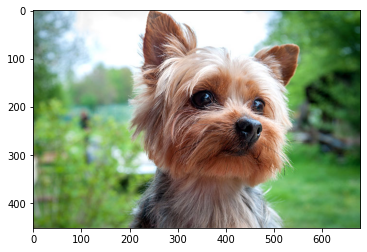

torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])


In [9]:
# read and visualize an image
img = cv.imread("data/images/dog.png")
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()
# define the transforms
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
img = np.array(img)
# apply the transforms
img = transform(img)
print(img.size())
# unsqueeze to add a batch dimension
img = img.unsqueeze(0)
print(img.size())

In [10]:
# pass the image through all the layers
results = [conv_layers[0](img)]
for i in range(1, len(conv_layers)):
    # pass the result from the last layer to the next layer
    results.append(conv_layers[i](results[-1]))
# make a copy of the `results`
outputs = results

In [11]:
#len(results)

In [12]:
# visualize 36 features from each layer 
# (although there are more feature maps in the upper layers)
all_layers_num = 5   # change the number of length to control how many layers you want to visualize
for num_layer in range(all_layers_num): 
    plt.figure(figsize=(20, 20))
    layer_viz = outputs[num_layer][0, :, :, :]
    layer_viz = layer_viz.data
    #print(layer_viz.size())
    for i, filter in enumerate(layer_viz):
        if i == 36: # we will visualize only 8x8 blocks from each layer
            break
        plt.subplot(6, 6, i + 1)
        plt.imshow(filter, cmap='gray')
        plt.axis("off")
    print(f"Saving layer {num_layer} feature maps...")
    plt.savefig(f"data/outputs/resnet/layer_{num_layer}.png")  # change the path to save the feature maps
    #plt.show() # use this line to show the figure in jupyter notebook
    plt.close()

Saving layer 0 feature maps...
Saving layer 1 feature maps...
Saving layer 2 feature maps...
Saving layer 3 feature maps...
Saving layer 4 feature maps...
